## Colab connect and download data set from kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 66 Dec 10 14:55 kaggle.json
100% 3.57G/3.58G [02:17<00:00, 28.0MB/s]
100% 3.58G/3.58G [02:17<00:00, 27.9MB/s]


In [ ]:
import zipfile
import os

curDir = os.getcwd()
print(curDir)

local_zip = '/content/fruits-fresh-and-rotten-for-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')

zip_ref.close()

/content



## Dataset preparation

Dataset train data에 지정한 폴더에서 random하게 image load 하여 출력

In [1]:
import random
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import os

filenames = os.listdir('/content/drive/MyDrive/ForTenProject/Kaggle/dataset/train/freshoranges')
sample = random.choice(filenames)
image = load_img('/content/drive/MyDrive/ForTenProject/Kaggle/dataset/train/freshoranges/'+sample)
plt.imshow(image)
print(image.size)

FileNotFoundError: ignored

## Module import

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

## Training Set

In [ ]:
# Dataset Gen을 하면서 로딩한 이미지에 대하여 1/255로 rescale을 함
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=15,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

# 이미지 target의 사이즈는 150, 150으로 잡고 해당 이미지 폴더를 읽을 때 10개의 이미지를 일으며 카테고리화를 한다.
train_generator = train_datagen.flow_from_directory(
                    '/content/drive/MyDrive/ForTenProject/Kaggle/dataset/train',
                    target_size = (150,150),
                    batch_size = 15,
                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
                    '/content/drive/MyDrive/ForTenProject/Kaggle/dataset/test',
                    target_size=(150,150),
                    batch_size= 15,
                    class_mode='categorical'
)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [ ]:
# Define a Callback function
desired_accuracy = 0.999

class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>desired_accuracy):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

my_callback = myCallback()


## Model Architecture

In [ ]:
baseModel = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(150, 150, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(6, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs = headModel)

# Freeze the baseModel layers
for layer in baseModel.layers :
    layer.trainable = False

94674944/94668760 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
## Hyperparameter
INIT_LR = 1e-3
BS = 15
EPOCHS = 25

In [ ]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            steps_per_epoch=len(train_generator) // BS,
            validation_steps=len(validation_generator) // BS,
            epochs=30,
            verbose=1,
            callbacks=[my_callback]
)

Epoch 1/30
48/48 [==============================] - 597s 12s/step - loss: 0.3732 - accuracy: 0.5625 - val_loss: 0.1480 - val_accuracy: 0.8278
Epoch 2/30
48/48 [==============================] - 582s 12s/step - loss: 0.1707 - accuracy: 0.7736 - val_loss: 0.1083 - val_accuracy: 0.8833
Epoch 3/30
48/48 [==============================] - 549s 11s/step - loss: 0.1315 - accuracy: 0.8444 - val_loss: 0.0785 - val_accuracy: 0.9222
Epoch 4/30
48/48 [==============================] - 486s 10s/step - loss: 0.1334 - accuracy: 0.8458 - val_loss: 0.0716 - val_accuracy: 0.9333
Epoch 5/30
48/48 [==============================] - 491s 10s/step - loss: 0.0949 - accuracy: 0.9042 - val_loss: 0.0428 - val_accuracy: 0.9444
Epoch 6/30
48/48 [==============================] - 427s 9s/step - loss: 0.0920 - accuracy: 0.9069 - val_loss: 0.0540 - val_accuracy: 0.9444
Epoch 7/30
48/48 [==============================] - 411s 9s/step - loss: 0.0868 - accuracy: 0.9014 - val_loss: 0.0385 - val_accuracy: 0.9722
Epoch 8/

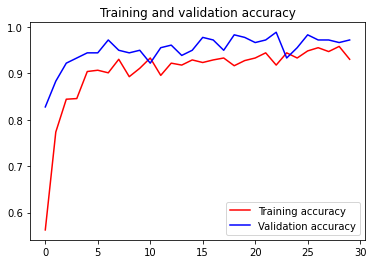

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
model.save('/content/drive/MyDrive/ForTenProject/FruitsRottenFresh/savemodel/transfer_learningv2.h5')